In [19]:
import sys 
import os
%pwd

'c:\\Users\\yashr\\OneDrive\\Desktop\\CMI_detect_sleep_states\\CMI-sleep-state-detection'

In [9]:
os.chdir("..")

In [20]:
%pwd

'c:\\Users\\yashr\\OneDrive\\Desktop\\CMI_detect_sleep_states\\CMI-sleep-state-detection'

In [21]:
from src.event_detection_ap import score


In [22]:
import pandas as pd
train_events = pd.read_csv("data/train_events.csv")

In [23]:
series_ids = train_events['series_id'].unique()

In [24]:
WINDOW_SIZE = int(2*60*60/5)
STEP_SIZE = int(20*60/5)

In [25]:
def load_data(series_id, window_size, step_size):
    features = ['awake', 'timestamp', 'anglez', 'enmo', 'step', 'series_id']

    _train_series = pd.read_csv("data/intermediate_data/train_series_{}.csv".format(series_id))

    _data = []
    for _start_step in range(0, len(_train_series)-window_size, step_size):
        _data.append(_train_series[features].iloc[_start_step:(_start_step+window_size)].values)

    _data = np.stack(_data)
    train_data = _data[np.all(_data[:,:,0]!=-1, axis=1),:,:]

    data_info = pd.DataFrame(
        train_data[:, int(window_size/2), np.isin(features, ['series_id', 'timestamp', 'step'])],
        columns = ['timestamp', 'step', 'series_id']
    )
    data_info['timestamp'] = pd.to_datetime(data_info['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles')

    X = train_data[:, :, np.isin(features, ['anglez', 'enmo'])].astype(np.float32)

    y = train_data[:, int(window_size/2), np.isin(features, ['awake'])].astype(np.int32)
    y = np.concatenate([y, 1-y], 1)
    
    return X, y, data_info

In [26]:
import numpy as np
from keras.utils import Sequence
import random

class MyGenerator(Sequence):
    def __init__(self, series_ids, batch_size, steps_per_epoch):
        self.series_ids = series_ids
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        
        self.num_X_used = 0
        self.num_called = 0

        self.X = np.empty(0)
        self.y = np.empty(0)

    def __len__(self):
        return self.steps_per_epoch
    
    def _load_data(self, series_id):
        X, y, _ = load_data(series_id, WINDOW_SIZE, STEP_SIZE)
        
        self.X = X
        self.y = y
        self.num_X_used = 0
        
    def __getitem__(self, idx):
        if (self.num_X_used > int(len(self.X)/self.batch_size)) or (len(self.X)==0):
            series_id = random.choice(self.series_ids)
            self._load_data(series_id)
            
        start_id = self.num_X_used*self.batch_size
        end_id = (self.num_X_used*self.batch_size+self.batch_size)

        batch_x = self.X[start_id:end_id,:,:]
        batch_y = self.y[start_id:end_id,:]
        
        self.num_called += 1
        self.num_X_used += 1
            
        if self.num_called==(self.steps_per_epoch-1):
            self.num_called = 0 
        
        return batch_x, batch_y

In [27]:
n_epoch = 300

batch_size = 8
steps_per_epoch = 50

my_generator = MyGenerator(series_ids, batch_size, steps_per_epoch)

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import LSTM
from keras.optimizers import Adam

# model = Sequential() 
# model.add(LSTM(128, batch_input_shape=(None, WINDOW_SIZE, 2)))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax')) 

model = Sequential() 
model.add(LSTM(128,return_sequences=True, batch_input_shape=(None, WINDOW_SIZE, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax')) 

model.compile(
    loss='binary_crossentropy', 
    optimizer=Adam(), 
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1440, 128)         67072     
                                                                 
 dropout (Dropout)           (None, 1440, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 87746 (342.76 KB)
Trainable params: 87746 (342.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/tmp/ipykernel_19/3909964496.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/300
50/50 [==============================] - 66s 1s/step - loss: 0.6457 - accuracy: 0.6100
Epoch 2/300
50/50 [==============================] - 97s 2s/step - loss: 0.6452 - accuracy: 0.6658
Epoch 3/300
50/50 [==============================] - 60s 1s/step - loss: 0.6478 - accuracy: 0.6150
Epoch 4/300
50/50 [==============================] - 87s 2s/step - loss: 0.5020 - accuracy: 0.8026
Epoch 5/300
50/50 [==============================] - 61s 1s/step - loss: 0.5449 - accuracy: 0.7475
Epoch 6/300
50/50 [==============================] - 60s 1s/step - loss: 0.4975 - accuracy: 0.7900
Epoch 7/300
50/50 [==============================] - 59s 1s/step - loss: 0.3932 - accuracy: 0.8600
Epoch 8/300
50/50 [==============================] - 71s 1s/step - loss: 0.5289 - accuracy: 0.7716
Epoch 9/300
50/50 [==============================] - 61s 1s/step - loss: 0.5079 - accuracy: 0.8000
Epoch 10/300
50/50 [==============================] - 87s 2s/step - loss: 0.4452 - accuracy: 0.8278
Epoch 11/

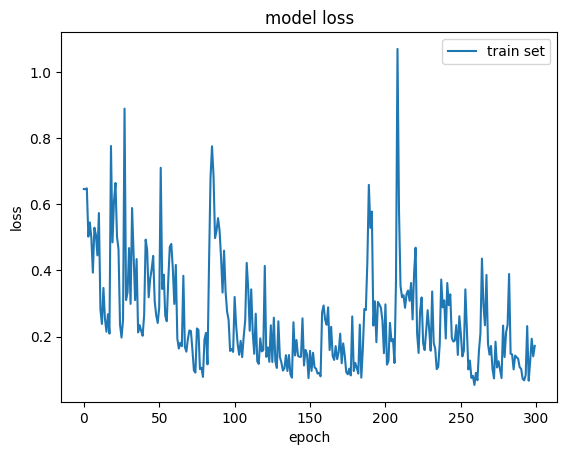

In [9]:
import matplotlib.pyplot as plt

hist = model.fit_generator(
    my_generator,
    epochs=n_epoch,
#     validation_data=(X_valid, y_valid),
    )

plt.plot(hist.history['loss'],label="train set")
# plt.plot(hist.history['val_loss'],label="test set")
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
model.save('lstm.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
series_id = series_ids[0]
X, y, data_info = load_data(series_id, WINDOW_SIZE, STEP_SIZE)

In [12]:
pred_y = model.predict(X) 

37/37 [==============================] - 25s 647ms/step


RMSE Score
  -  0.44574241986994895


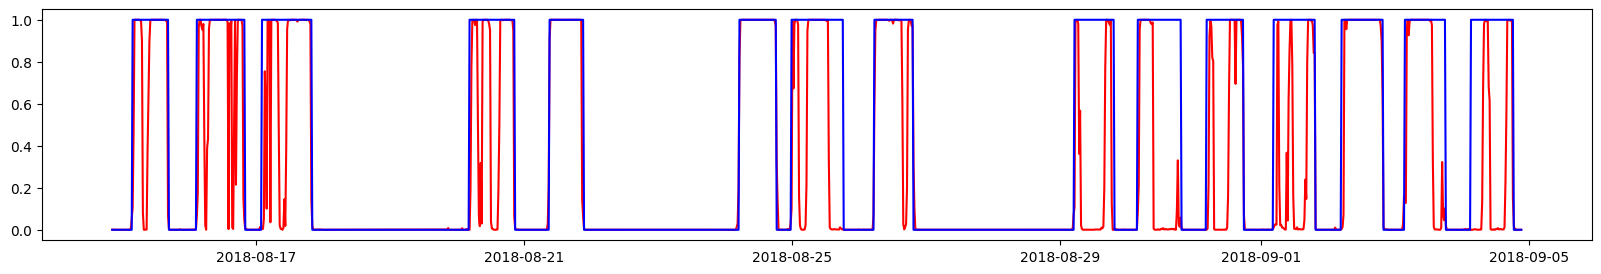

In [13]:
import numpy as np

def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

print("RMSE Score")
print("  - " , rmse(pred_y[:,0], y[:,0]))

pred_y_df = pd.DataFrame(pred_y[:,0])
pred_y_df.index = data_info['timestamp']

y_df = pd.DataFrame(y[:,0])
y_df.index = data_info['timestamp']

fig, ax = plt.subplots(figsize=(20, 3))
ax.plot(pred_y_df, color='red',  label="train")
ax.plot(y_df, color='blue',  label="observed")
plt.show()

In [14]:
def get_events(preds, probs, test, prediction_window=10+1, score_window=10+1) :
    test.loc[:, 'prediction'] = preds
    test.loc[:, 'prediction'] = test['prediction'].rolling(prediction_window, center=True).median()
    test.loc[:, 'probability'] = probs
    
    # test.loc[test['prediction']==0, 'probability'] = 1-test.loc[test['prediction']==0, 'probability']
    test.loc[:, 'score'] = test['probability'].rolling(score_window, center=True, min_periods=10).mean().bfill().ffill()

    test.loc[:, 'pred_diff'] = test['prediction'].diff()
    
    test.loc[:, 'event'] = test['pred_diff'].replace({1:'wakeup', -1:'onset', 0:np.nan})
    
    test_wakeup = test[test['event']=='wakeup'].groupby(test['timestamp'].dt.date).agg('first')
    test_onset = test[test['event']=='onset'].groupby(test['timestamp'].dt.date).agg('last')
    test = pd.concat([test_wakeup, test_onset], ignore_index=True).sort_values('timestamp')
    
    test['step'] = test['step'].astype('int32')

    return test

preds = 1-np.argmax(pred_y, axis=1)
probs = np.max(pred_y, axis=1)

predict_events = get_events(preds, probs, data_info)
predict_events

,timestamp,step,series_id,prediction,probability,score,pred_diff,event
0,2018-08-15 04:30:00-07:00,11520,038441c925bb,1.0,0.999940,0.943365,1.0,wakeup
15,2018-08-15 16:30:00-07:00,20160,038441c925bb,0.0,0.933931,0.991849,-1.0,onset
1,2018-08-16 03:30:00-07:00,28080,038441c925bb,1.0,0.965727,0.965575,1.0,wakeup
16,2018-08-16 19:30:00-07:00,39600,038441c925bb,0.0,0.846380,0.978500,-1.0,onset
2,2018-08-17 03:50:00-07:00,45600,038441c925bb,1.0,0.899316,0.917825,1.0,wakeup
17,2018-08-17 19:50:00-07:00,57120,038441c925bb,0.0,0.857009,0.982173,-1.0,onset
3,2018-08-20 05:10:00-07:00,98400,038441c925bb,1.0,0.779613,0.959445,1.0,wakeup
18,2018-08-20 20:30:00-07:00,109440,038441c925bb,0.0,0.936865,0.988167,-1.0,onset
4,2018-08-21 09:10:00-07:00,118560,038441c925bb,1.0,0.911085,0.970780,1.0,wakeup
19,2018-08-21 20:50:00-07:00,126960,038441c925bb,0.0,0.859137,0.981007,-1.0,onset


In [15]:
tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

series_id_column_name = "series_id"
time_column_name = "step"
event_column_name = "event"
score_column_name = "score"
use_scoring_intervals = None

score(
        train_events,
        predict_events,
        tolerances,
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
        use_scoring_intervals
)

0.00027104068770735434